In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=''

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=''


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [6]:
from sklearn.datasets import make_moons

In [7]:
X_train, Y_train = make_moons(1000, random_state=0, noise=0.1)
X_train_flat = X_train

In [8]:
X_test, Y_test = make_moons(1000, random_state=1, noise=0.1)
X_test_flat = X_test

In [9]:
X_valid, Y_valid = make_moons(1000, random_state=2, noise=0.1)

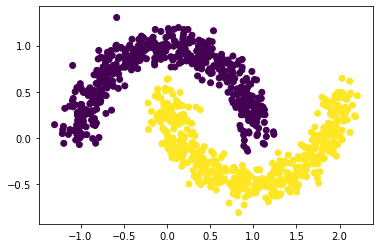

In [10]:
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test)

### Create model and train

In [17]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=100,
)

In [18]:
z = embedder.fit_transform(X_train_flat)

tfUMAP(negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fb9580bb860>,
       tensorboard_logdir='/tmp/tensorboard/20200709-104758',
       training_epochs=100)
Construct fuzzy simplicial set
Thu Jul  9 10:47:59 2020 Finding Nearest Neighbors
Thu Jul  9 10:47:59 2020 Finished Nearest Neighbor Search
Thu Jul  9 10:47:59 2020 Embedding with TensorFlow


Thu Jul  9 10:49:18 2020 Finished embedding


### Plot model output

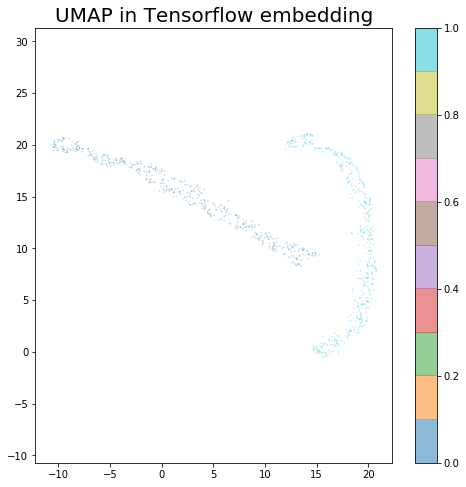

In [19]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [20]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [21]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss']
[]


,wall_time,step,val,group,variable
0,1.594317e+09,1,4.002271,train,umap_loss
1,1.594317e+09,2,3.586475,train,umap_loss
2,1.594317e+09,3,3.266968,train,umap_loss


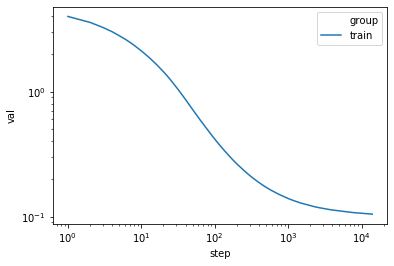

In [22]:
ax = sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'])
ax.set_xscale('log')
ax.set_yscale('log')

### Save output

In [23]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [24]:
output_dir = MODEL_DIR/'projections'/ 'moons' / 'network'
ensure_dir(output_dir)

In [25]:
embedder.save(output_dir)

Pickle of model saved


W0709 10:49:57.324843 140437202163520 deprecation.py:506] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
I0709 10:49:57.389221 140437202163520 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/moons/network/encoder/assets


Encoder Keras model saved


In [26]:
loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [27]:
np.save(output_dir / 'z.npy', z)

### Compare to direct embedding with base UMAP

In [28]:
from umap import UMAP

In [29]:
z_umap = UMAP(verbose=True).fit_transform(X_train_flat)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Thu Jul  9 10:49:58 2020 Finding Nearest Neighbors
Thu Jul  9 10:49:58 2020 Finished Nearest Neighbor Search
Thu Jul  9 10:49:58 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Jul  9 10:50:01 2020 Finished embedding


In [30]:
### realign using procrustes 
from scipy.spatial import procrustes
z_align, z_umap_align, disparity = procrustes(z, z_umap)
print(disparity)

0.5616648093965688


Text(0.5, 1.0, 'UMAP with UMAP-learn')

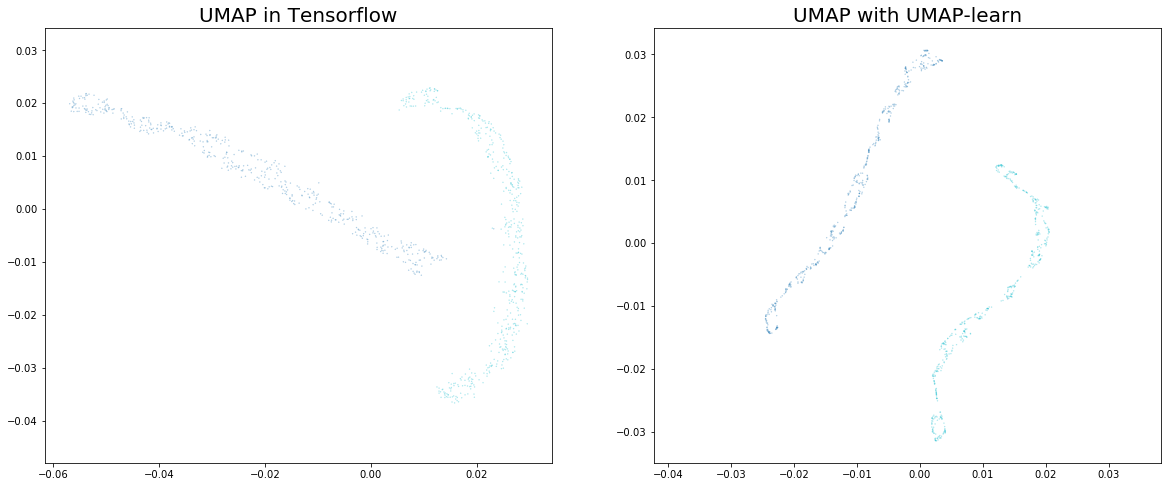

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
ax = axs[0]
sc = ax.scatter(
    z_align[:, 0],
    z_align[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow", fontsize=20)
#plt.colorbar(sc, ax=ax);

ax = axs[1]
sc = ax.scatter(
    z_umap_align[:, 0],
    z_umap_align[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP with UMAP-learn", fontsize=20)
#plt.colorbar(sc, ax=ax);